# DNN Assignment
In this assignment you are working together with your teammates from the second project. You will apply your new knowledge about dense neural networks to the data from your ML project to investigate, if you can make further improvements on prediction performance. Your data is (hopefully) already cleaned and transformed (this was part of your ML project) such that you can focus fully on feeding it to your neural network. Use TensorFlow 2.x in this assignment as it makes training with real-life data much more easier with many implemented features (e.g. early-stopping, TensorBoard, regularization, etc.). 

In this notebook you will learn
- how to apply a neural network to your own data using TensorFlow 2.x
- how to tune the network and monitor learning
- how to train several networks and ensemble them into a stronger model

# Module loading
Load all the necessary packages for your assignment. We give you some modules in advance, feel free to add more, if you need them.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers
    
print('Using TensorFlow version: %s' % tf.__version__)

Using TensorFlow version: 2.8.0


In [2]:
#!pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import datetime, time, os

In [3]:
from sklearn.pipeline import Pipeline # focus on this one
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, roc_auc_score, f1_score, roc_curve, r2_score, fbeta_score,cohen_kappa_score, f1_score

## Data loading
Load here your data from your ML project. You can use either `pandas` or `numpy` to format your data. 

In [4]:
# Load data
df = pd.read_pickle("df_train_1.pkl")
df

,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,...,L3_NO2_cloud_fraction,L3_CO_CO_column_number_density,L3_CO_cloud_height,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_cloud_fraction,L3_O3_O3_column_number_density,L3_O3_cloud_fraction,L3_SO2_SO2_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction
0,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,0.00804,...,0.006507,0.021080,267.017184,0.000064,0.000000,0.119095,0.000000,-0.000127,-1.861476,0.000000
1,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,0.00839,...,0.018360,0.022017,61.216687,0.000171,0.059433,0.115179,0.059433,0.000150,-1.452612,0.059433
2,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,0.00750,...,0.015904,0.020677,134.700335,0.000124,0.082063,0.115876,0.082063,0.000150,-1.572950,0.082063
3,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,0.00391,...,0.055765,0.021207,474.821444,0.000081,0.121261,0.141557,0.121261,0.000227,-1.239317,0.121261
4,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,0.00535,...,0.028530,0.037766,926.926310,0.000140,0.037919,0.126369,0.037919,0.000390,0.202489,0.037919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30552,2020-03-15,YWSFY6Q,22.0,14.0,83.0,3848.86,72,6.700000,68.300003,0.00352,...,0.001107,0.039941,192.388239,0.000024,0.001310,0.174995,0.001310,0.000312,-1.953480,0.001310
30553,2020-03-16,YWSFY6Q,53.0,30.0,146.0,9823.87,72,6.300000,77.700005,0.00341,...,0.004726,0.037872,61.379434,-0.000014,0.007644,0.157659,0.007644,0.000362,-2.178236,0.007644
30554,2020-03-17,YWSFY6Q,85.0,52.0,153.0,8900.85,72,7.100000,68.500000,0.00356,...,0.026249,0.038539,1572.596434,0.000094,0.025447,0.168295,0.025447,0.000107,-2.365827,0.025447
30555,2020-03-18,YWSFY6Q,103.0,33.0,149.0,13963.90,72,19.100000,66.300003,0.00523,...,0.144318,0.038757,846.961465,0.000063,0.103292,0.160637,0.173391,0.000014,-2.784346,0.153445


In [5]:
# create windstrength column
df['windstrength'] = np.sqrt(df.u_component_of_wind_10m_above_ground**2 + df.v_component_of_wind_10m_above_ground**2)
df.windstrength.describe()

count    30557.000000
mean         3.100731
std          2.209016
min          0.020040
25%          1.497562
50%          2.545925
75%          4.152956
max         18.160623
Name: windstrength, dtype: float64

In [6]:
import pandas as pd
from datetime import datetime, date, time, timedelta

In [7]:
# change date to datetime
df.Date = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# change date to datetime
df['weekday'] = df.Date.dt.dayofweek

# Dropping the unnecessary columns 
df.drop(['Date',
         #'Place_ID',
         'target_min',
         'target_max',
         'target_variance',
         'target_count',
         'u_component_of_wind_10m_above_ground',
         'v_component_of_wind_10m_above_ground',
         ], axis=1, inplace=True)
df.columns

df.dropna(thresh=len(df.columns)-8, inplace=True)

df = df.reset_index(drop=True)

df["target"] = pd.cut(df.target, bins=[0, 35, 115, 850], labels=['0', '1', '2'])

In [8]:
# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(df.columns[df.dtypes==object])


# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
time_features = ['weekday']


# Creating list for numerical predictors/features
# Since 'target' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = [#'target_min', 'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground',
       'temperature_2m_above_ground',
       #'u_component_of_wind_10m_above_ground',
       #'v_component_of_wind_10m_above_ground'
       'windstrength'
       ]


# Creating list for numerical predictors/features
# Since 'outcome' is our target variable we will exclude this feature from this list of numerical predictors 
miss_features = ['L3_AER_AI_absorbing_aerosol_index', 
       'L3_CLOUD_cloud_base_height',
       'L3_CLOUD_cloud_fraction', 
       'L3_CLOUD_cloud_optical_depth',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_cloud_fraction', 
       'L3_CO_cloud_height',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'L3_HCHO_cloud_fraction', 
       'L3_SO2_SO2_column_number_density',
       'L3_SO2_cloud_fraction']


replace_features = ["L3_NO2_absorbing_aerosol_index",
                    "L3_CO_CO_column_number_density",
                    "L3_O3_O3_column_number_density",
                    "L3_O3_cloud_fraction",
                    "L3_SO2_absorbing_aerosol_index"]

In [9]:
# Define predictors and target variable
X = df.drop('target', axis=1)
y = df['target']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 28613 observations in our dataset and 23 features
Our target vector has also 28613 values


In [10]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [11]:
y_train = y_train.astype(int)

In [12]:

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# Pipeline for missing values: in this case missing values are nan!
miss_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median',missing_values=np.nan)),
    ('std_scaler', StandardScaler())
])
# replace 0 values
# Pipeline for missing values: in this case missing values are 0!
replace_pipeline = Pipeline([
    ('imputer_null', SimpleImputer(strategy='constant', fill_value = 0)),
    ('imputer_nan', SimpleImputer(strategy='median', missing_values= 0)),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    #('imputer_cat', SimpleImputer(strategy='constant',fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for categorical features 
time_pipeline = Pipeline([
    #('imputer_cat', SimpleImputer(strategy='constant',fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
    ])

#from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('miss', miss_pipeline, miss_features),
    ('replace', replace_pipeline, replace_features),
    ('time', time_pipeline, time_features)
    ], sparse_threshold=0)

In [13]:
X_train_transformed = preprocessor.fit_transform(X_train)

In [14]:
X_train_transformed.shape

X_tf_train = tf.convert_to_tensor(X_train_transformed)
y_tf_train = tf.convert_to_tensor(y_train)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-22 15:47:00.773607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-22 15:47:00.773736: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training
For training you need a train/val split (hopefully you did a train/test split before (and you should use the same as in your ML project to make results comparable). 

In [15]:
# Define dictionary to store results
training_history = {}

# Define number of epochs and learning rate decay
N_TRAIN = len(X_train)
N_VAL = 0.2
EPOCHS = 200
BATCH_SIZE = N_TRAIN // 10
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#     0.01,
#     decay_steps=STEPS_PER_EPOCH*1000,
#     decay_rate=1,
#     staircase=False)

### Build, compile and fit your model
To become fast at retraining your (different) models it is good practice to define a function that gets fed by a model, its name, an optimizer to use and the number of epochs you want the model to be trained. 

If your model trains for many epochs you will receive a lot of logging from TensorFlow. To reduce the logging noise you can use a callback (provided by the `tensorflow_docs` module we installed and imported for you) named `EpochDots()` that simply prints a `.` for each epoch and a full set of metrics after a number of epochs have been trained. 

If you want to produce logs for using TensorBoard you also need to include the `callbacks.TensorBoard()`.

In [16]:
from datetime import datetime
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")

# Define function for creating a new folder for each run
def get_run_logdir():
    now = datetime.now()
    run_id = now.strftime('%Y-%m-%d %H:%M:%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [17]:
#def get_callbacks():
# Define path where checkpoints should be stored
checkpoint_path = "training_1/ML_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0) # Set verbose != 0 if you want output during training 
# return [list of your callbacks]
def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)

You can implement your callbacks in the `model.fit()` method below.

In [18]:
def model_compile_and_fit(model, name, optimizer=None, max_epochs=EPOCHS):
  
    # model.compile

    model.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    # model.fit

    history = model.fit(X_tf_train, y_train, batch_size = BATCH_SIZE, validation_split=N_VAL, epochs = max_epochs)
    # return results
    # return {name:history}
    return history

#### Build your model
You can build your model by using `tf.keras.Sequential()` that helps you to sequentially define your different layers from input to output. 

In [19]:
with tf.device('/cpu:0'):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = 368),
    tf.keras.layers.Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 3,kernel_initializer = 'uniform', activation = 'softmax')
    ])  

#### Train your model
Train your model by using your `model_compile_and_fit()` function you defined above.

In [20]:
#your_history = model_compile_and_fit(your_model, ....)
with tf.device('/cpu:0'):
    training_history["firstmodel"] = model_compile_and_fit(model, "firstmodel")

Epoch 1/200


2023-02-22 15:47:01.121407: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - 1s 26ms/step - loss: 1.0960 - accuracy: 0.4887 - val_loss: 1.0920 - val_accuracy: 0.5112
Epoch 2/200
9/9 [==============================] - 0s 6ms/step - loss: 1.0893 - accuracy: 0.5215 - val_loss: 1.0866 - val_accuracy: 0.5112
Epoch 3/200
9/9 [==============================] - 0s 7ms/step - loss: 1.0840 - accuracy: 0.5215 - val_loss: 1.0801 - val_accuracy: 0.5112
Epoch 4/200
9/9 [==============================] - 0s 10ms/step - loss: 1.0775 - accuracy: 0.5215 - val_loss: 1.0760 - val_accuracy: 0.5112
Epoch 5/200
9/9 [==============================] - 0s 6ms/step - loss: 1.0734 - accuracy: 0.5215 - val_loss: 1.0702 - val_accuracy: 0.5112
Epoch 6/200
9/9 [==============================] - 0s 7ms/step - loss: 1.0676 - accuracy: 0.5215 - val_loss: 1.0655 - val_accuracy: 0.5112
Epoch 7/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0629 - accuracy: 0.5215 - val_loss: 1.0610 - val_accuracy: 0.5112
Epoch 8/200
9/9 [====================

#### Evaluate your model training
TensorFlow offers now (this was more cumbersome before) a simple history plotter that you can use to plot training histories and see how the model performed on training and validation data set.

In [36]:
training_history

{'firstmodel': <keras.callbacks.History at 0x2b8c1ae50>,
 'second_model': <keras.callbacks.History at 0x2b8edffa0>,
 'third_model': <keras.callbacks.History at 0x2b8ffef70>}

In [21]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

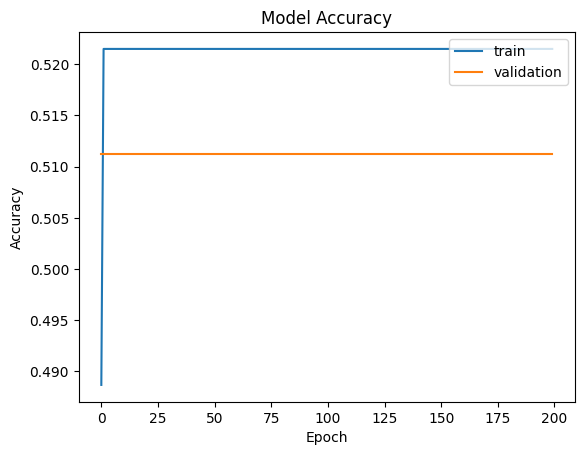

In [22]:
plot_metric(training_history['firstmodel'])

In [23]:
# Plotting function for loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

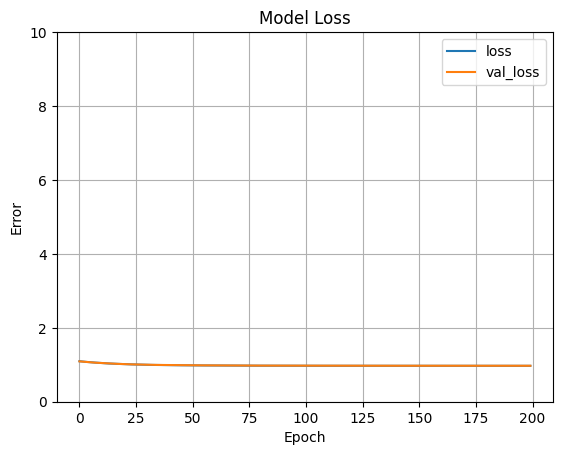

In [24]:
plot_loss(training_history["firstmodel"])

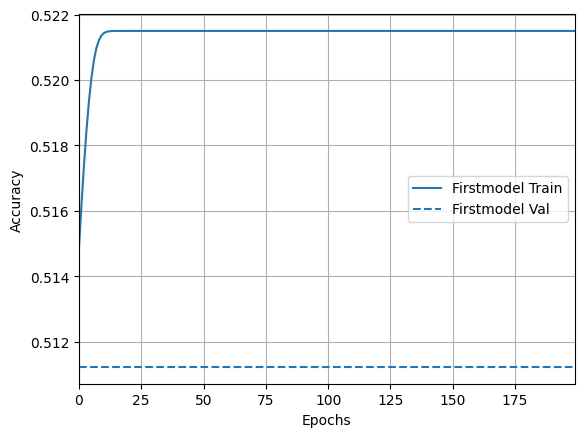

In [25]:
history_plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
history_plotter.plot(training_history)

## Model tuning
You might have no luck with your first model (most surely you did not). In this section you will apply methods you know to tune your model's performance. An obvious way of course is to change your model's architecture (removing or adding layers or layer dimensions, changing activation functions). 

However, after this you might still be able to detect some overfitting and there are some more methods you can apply to improve your neural network. Some of them are regularization, learning rate decay, early stopping, or dropout. 

If you want to add regularization you can apply directly layer-wise L2- or L1-regularization by using a layer's `kernel_regularization` argument and an appropriate regularizer from the [`tensorflow.keras.regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) module we imported for you.  

__Optimizer schedules__<br>
Quite often your optimizer does not run efficiently through the loss function surface. Remember that theory ensures a convergence of mini-batch SGD if and only if the learing rate decreases sufficiently fast. A way to apply this to your model training is to use a learning rate scheduler (learning rate decay) that reduces the learning rate over the number of update steps. The [`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) module offers you some approaches to do that. 

Note that to apply this to your `model_compile_and_fit()` function you defined above you need to implement the learning rate schedule either in there or with a helper function that your function calls inside. 

If you want to visualize different schedulers you can define them and call them on a range of values and plot them in a line plot. 

__Early stopping__<br>
Earyl stopping is a procedure that enables you to stop your training earlier than defined by your `max_epochs` argument. It is used in practices to 
1. determine the optimal parameter vector by monitoring the validation error closely (if it rises again too much stuck with the best parameters found until then) and
2. to save expensive resources (either in terms of monetary costs or ecological costs).

To implement early stopping in TensorFlow the `tf.keras` module offers you a `callback` named [`tf.keras.callback.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) that monitors for you a certain metric (it makes sense here to use a validation metric) and to stop training after a certain number of epochs with no improvement or by defining a certain `min_delta` that defines a minimum value of improvement - if below the callback stops your training. 

You can add this callback simply to the callbacks defined in your `get_callbacks()` function you defined above.

__Dropout__<br>
Dropout was one of the important developments in regularization for neural networks. It was developed by Geoffrey Hinton and his team at Toronto University. 

Dropout can be applied to each layer in your network and is implemented in `tf.keras` by an own layer named `Dropout()` awaiting a dropout rate set by you. So to introduce dropout you have to rework your model design.  

Make use of your knowledge and apply tuning techniques to improve your network. 

In [26]:
#===========#
# Second Model with more nodes
#===========#

with tf.device('/cpu:0'):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu', input_dim = 368),
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 3,kernel_initializer = 'uniform', activation = 'softmax')
    ])  

#your_history = model_compile_and_fit(your_model, ....)
with tf.device('/cpu:0'):
    training_history["second_model"] = model_compile_and_fit(model, "second_model")

Epoch 1/200
9/9 [==============================] - 0s 12ms/step - loss: 1.0963 - accuracy: 0.4724 - val_loss: 1.0919 - val_accuracy: 0.5112
Epoch 2/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0893 - accuracy: 0.5215 - val_loss: 1.0853 - val_accuracy: 0.5112
Epoch 3/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0827 - accuracy: 0.5215 - val_loss: 1.0794 - val_accuracy: 0.5112
Epoch 4/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0769 - accuracy: 0.5215 - val_loss: 1.0746 - val_accuracy: 0.5112
Epoch 5/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0720 - accuracy: 0.5215 - val_loss: 1.0692 - val_accuracy: 0.5112
Epoch 6/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0667 - accuracy: 0.5215 - val_loss: 1.0637 - val_accuracy: 0.5112
Epoch 7/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0612 - accuracy: 0.5215 - val_loss: 1.0594 - val_accuracy: 0.5112
Epoch 8/200
9/9 [=========

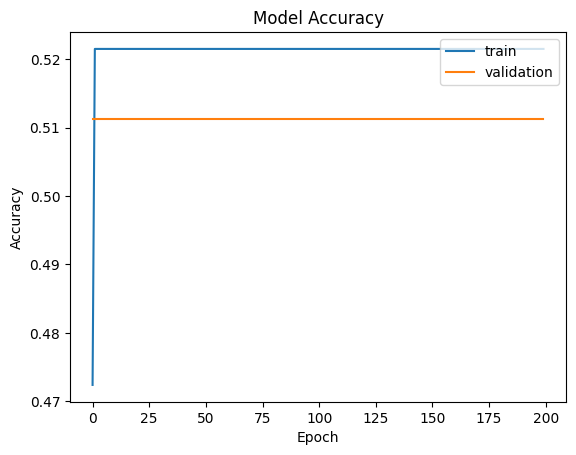

In [27]:
plot_metric(training_history['second_model'])

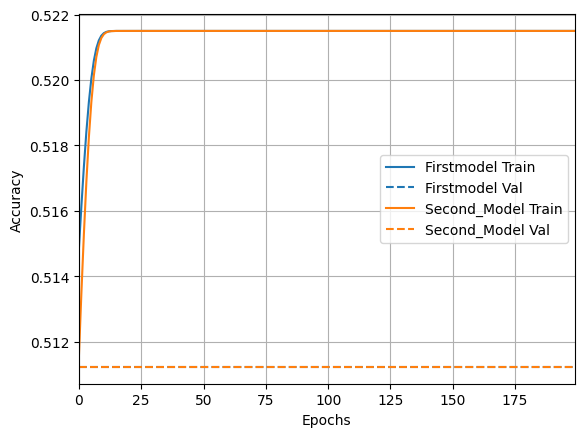

In [28]:
history_plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
history_plotter.plot(training_history)

In [29]:
#===========#
# Third Model with more layers
#===========#

with tf.device('/cpu:0'):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu', input_dim = 368),
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 3,kernel_initializer = 'uniform', activation = 'softmax')
    ])  

#your_history = model_compile_and_fit(your_model, ....)
with tf.device('/cpu:0'):
    training_history["third_model"] = model_compile_and_fit(model, "third_model")

Epoch 1/200
9/9 [==============================] - 0s 14ms/step - loss: 1.0959 - accuracy: 0.5054 - val_loss: 1.0917 - val_accuracy: 0.5112
Epoch 2/200
9/9 [==============================] - 0s 6ms/step - loss: 1.0891 - accuracy: 0.5215 - val_loss: 1.0858 - val_accuracy: 0.5112
Epoch 3/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0832 - accuracy: 0.5215 - val_loss: 1.0793 - val_accuracy: 0.5112
Epoch 4/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0767 - accuracy: 0.5215 - val_loss: 1.0731 - val_accuracy: 0.5112
Epoch 5/200
9/9 [==============================] - 0s 5ms/step - loss: 1.0705 - accuracy: 0.5215 - val_loss: 1.0677 - val_accuracy: 0.5112
Epoch 6/200
9/9 [==============================] - 0s 6ms/step - loss: 1.0651 - accuracy: 0.5215 - val_loss: 1.0627 - val_accuracy: 0.5112
Epoch 7/200
9/9 [==============================] - 0s 6ms/step - loss: 1.0602 - accuracy: 0.5215 - val_loss: 1.0586 - val_accuracy: 0.5112
Epoch 8/200
9/9 [=========

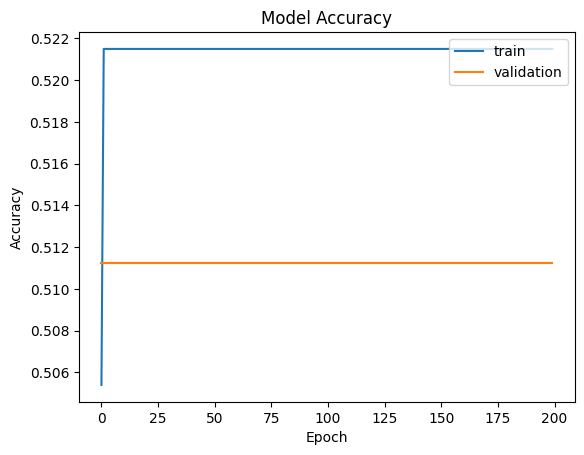

In [30]:
plot_metric(training_history['third_model'])

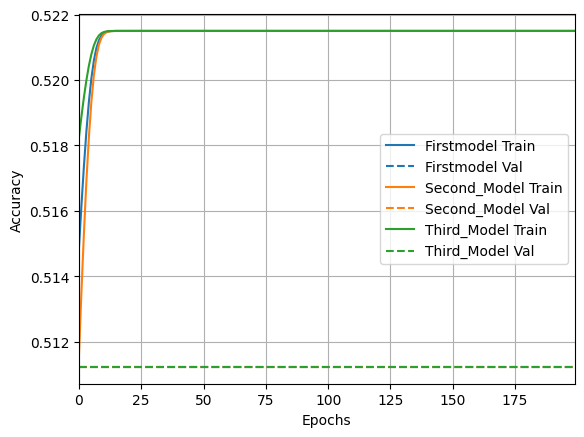

In [31]:
history_plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
history_plotter.plot(training_history)

In [32]:
training_history

{'firstmodel': <keras.callbacks.History at 0x2b8c1ae50>,
 'second_model': <keras.callbacks.History at 0x2b8edffa0>,
 'third_model': <keras.callbacks.History at 0x2b8ffef70>}

In [33]:
# Instantiate HistoryPlotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)

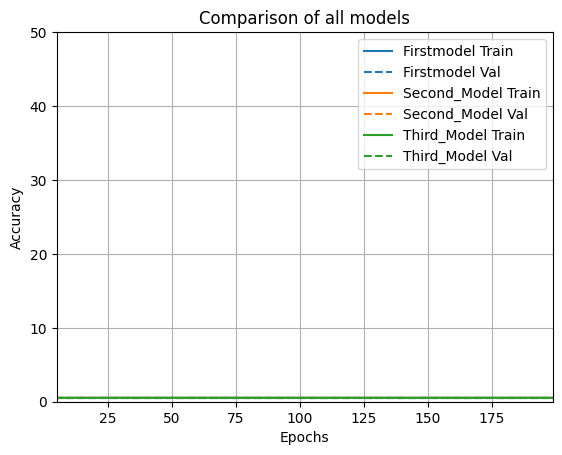

In [34]:
plotter.plot(training_history)
plt.xlim([5, max(plt.xlim())])
plt.ylim([0, 50])
plt.xlabel('Epochs')
plt.title('Comparison of all models')
plt.legend(loc='upper right');

In [37]:
#===========#
# Fourth Model with more layers
#===========#

with tf.device('/cpu:0'):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu', input_dim = 368),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units= 3,kernel_initializer = 'uniform', activation = 'softmax')
    ])  

#your_history = model_compile_and_fit(your_model, ....)
with tf.device('/cpu:0'):
    training_history["fourth_model"] = model_compile_and_fit(model, "fourth_model")

Epoch 1/200
9/9 [==============================] - 0s 16ms/step - loss: 1.0959 - accuracy: 0.4859 - val_loss: 1.0913 - val_accuracy: 0.5112
Epoch 2/200
9/9 [==============================] - 0s 6ms/step - loss: 1.0887 - accuracy: 0.5215 - val_loss: 1.0848 - val_accuracy: 0.5112
Epoch 3/200
9/9 [==============================] - 0s 7ms/step - loss: 1.0821 - accuracy: 0.5215 - val_loss: 1.0791 - val_accuracy: 0.5112
Epoch 4/200
9/9 [==============================] - 0s 7ms/step - loss: 1.0765 - accuracy: 0.5215 - val_loss: 1.0734 - val_accuracy: 0.5112
Epoch 5/200
9/9 [==============================] - 0s 7ms/step - loss: 1.0707 - accuracy: 0.5215 - val_loss: 1.0686 - val_accuracy: 0.5112
Epoch 6/200
9/9 [==============================] - 0s 8ms/step - loss: 1.0659 - accuracy: 0.5215 - val_loss: 1.0634 - val_accuracy: 0.5112
Epoch 7/200
9/9 [==============================] - 0s 8ms/step - loss: 1.0608 - accuracy: 0.5215 - val_loss: 1.0598 - val_accuracy: 0.5112
Epoch 8/200
9/9 [=========

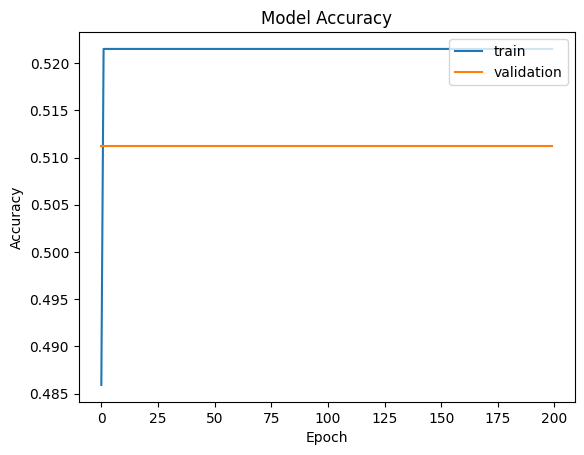

In [38]:
plot_metric(training_history['fourth_model'])

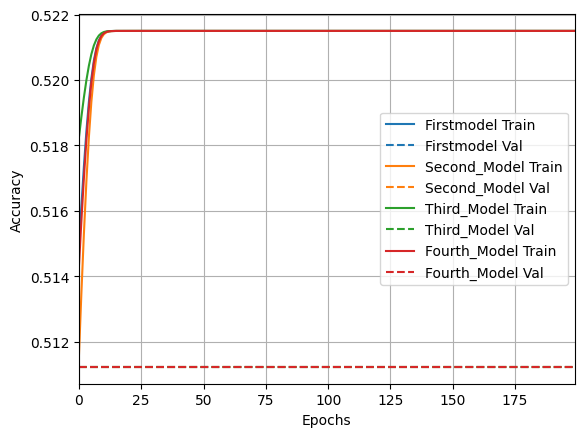

In [39]:
history_plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
history_plotter.plot(training_history)

## Model ensembling
You have learned that models can be ensembled. What is possible in `scikit-learn` is also possible in TensorFlow, just a little different as it is relying on its computation graph. However, any model is callable like a `layer` by invoking it on either an `Input` or on the output of another layer. Furthermore, you can also stack outputs together.

To produce an ensemble you can define a couple of models, than use their predictions as inputs for another model and produce a final output (using `keras.Model(input, output)`). But you can also start simple and use the mean predictions over all models and then compute the `argmax()` to assign them to a class in classification (via using `layers.average([model1_preds,model2_preds,...])`). You will be surprised how well this works. 

Now implement your own ensemble to improve your work even a little more and to have something more to polish up your ML project on `GitHub` ;) 

In [35]:
#===========#
# YOUR CODE #
#===========#